In [1]:
# import packages
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle



# get api keys for binance 
import os
API_PUBLIC = os.environ.get("PUBLIC_KEY")
API_SECRET = os.environ.get("SECRET_KEY")

In [2]:
with open('cryptopairs20102020.pkl', 'rb') as handle:
    df = pickle.load(handle)

/home/joseph/.local/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


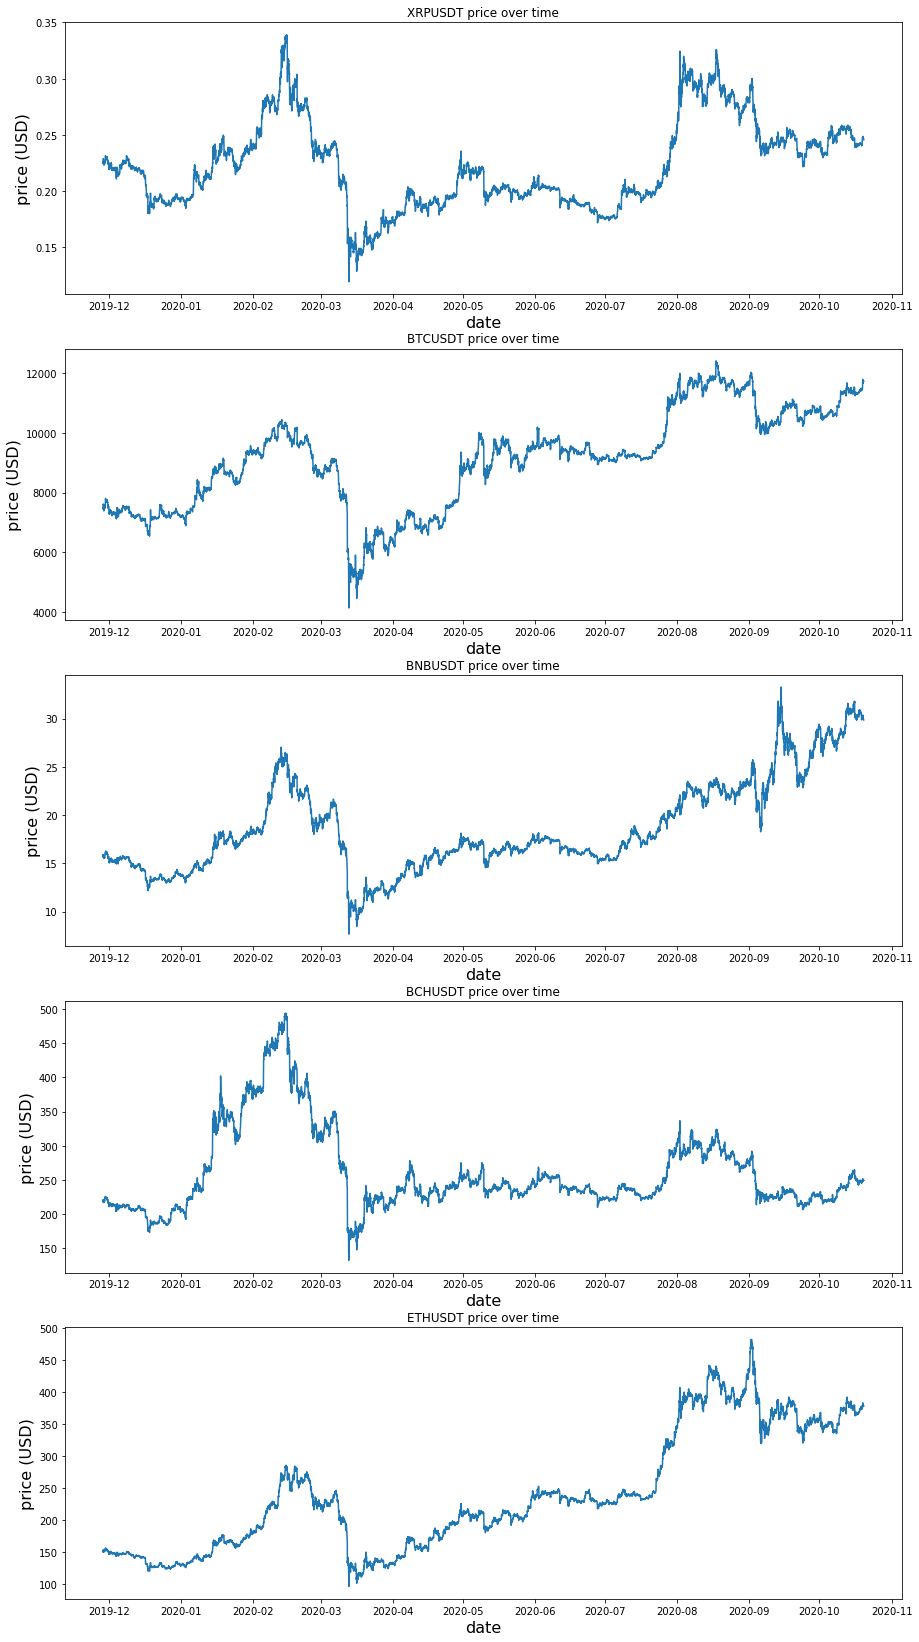

In [3]:
fig, ax = plt.subplots(len(df),figsize=(15, 29))

for i in range(len(df)):
    ax[i].plot(df[list(df.keys())[i]]['close']) # stacked plot of each of the currencies
    ax[i].set_title(list(df.keys())[i] + ' price over time') # set plot titles
    

# set axes labels
for i in range(len(df)):
    ax[i].set_xlabel('date',fontsize=16)
    ax[i].set_ylabel('price (USD)', fontsize=16)

pairs trading on XRP/BTC pair

In [12]:
# calculate spread on BTC/XRP pair on adjusted close
# should do regression and correlation analysis first
df_spread = df['BTCUSDT']['close'] - df['XRPUSDT']['close']

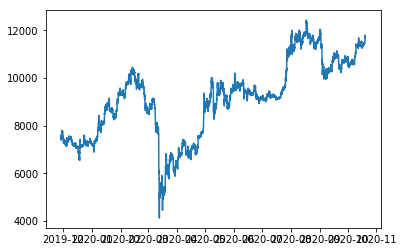

In [14]:
plt.plot(df_spread)